In [2]:
import time
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

params = {
    # 'font.family': 'Inter',
    'font.family': 'sans-serif',
    'legend.fontsize': 'x-small',
    'axes.labelsize': 'x-small',
    'axes.titlesize': 'x-small',
    'xtick.labelsize': 'x-small',
    'ytick.labelsize': 'x-small',
    # 'figure.figsize': (3.0, 1.7),
}
plt.rcParams.update(params)
plt.clf()

def parse_timestamp(timestamp_str):
    # 2024-04-12 14:45:40.00857
    # to datetime object
    return pd.to_datetime(timestamp_str, format='%Y-%m-%d %H:%M:%S.%f')

def parse_func_name(func_name_str):
    # Func:'load_index' => "load_index"
    str_l = func_name_str.split(":")
    if "completed" in func_name_str:
        return func_name_str
    return str_l[-1][:]

def parse_latency(time_str):
    return float(time_str[:-1])

def create_gantt_chart(load_index_hbars, search_index_hbars, figsize=(6, 1), ax=None, vline=True):
    return_ax = False
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        return_ax = True

    bar_width = 0.5
    bar_gap = 0.0
    # [(x, length), ()], (y, bar_width)
    ax.broken_barh(load_index_hbars[:], (1, bar_width), facecolors =('darkorange'))
    ax.broken_barh(search_index_hbars[:], (1+bar_width+bar_gap, bar_width), facecolors =('green'))

    ax.set_yticks([1+bar_width/2, 1+bar_width+bar_gap+bar_width/2], ['load', 'search'])
    # ax.grid(True, alpha=0.5)

    if vline:
        last_x = search_index_hbars[-1][0]+search_index_hbars[-1][1]
        ax.axvline(x=last_x, color='black', linestyle='--', alpha=1)

    if return_ax:
        return fig, ax
    return ax

log_headers = ["timesteps", "start_time", "action", "latency", "file_path", "num_query"]

<Figure size 640x480 with 0 Axes>

In [3]:
def construct_load_search_bars(fpths, log_headers):
    df = pd.read_csv(fpths, header=None)
    df.columns = log_headers
    df["action"] = df["action"].map(parse_func_name)
    df["latency"] = df["latency"].map(parse_latency)
    df['start_time'] = df['start_time'] - df['start_time'][0]
    load_index_hbars = []
    search_index_hbars = []
    for i, row in df[df["action"] == "load_index"].iterrows():
        load_index_hbars.append((row["start_time"], row["latency"]))
    for i, row in df[df["action"] == "query_index"].iterrows():
        search_index_hbars.append((row["start_time"], row["latency"]))
    return load_index_hbars, search_index_hbars

In [4]:
st = "index_async"
total_idx = 1000
mem_list = []
for i in np.arange(0, 1.1, 0.1):
    mem_list.append(int(total_idx * i))

diverse_list = []
for i in np.arange(0, 1.1, 0.1):
    diverse_list.append(i)

for m in diverse_list:
    # if m==0: m=1
    fp = "../logs/st_{}_{}_batch.log".format(st, m)
    print(fp)
    try:
        l, s = construct_load_search_bars(fp, log_headers)
        fig, ax = create_gantt_chart(l, s, ax=None)
        fig.tight_layout()
        fig.savefig("tmp/st_{}_{}_batch.pdf".format(st, m))
        plt.show()
    except:
        pass

../logs/st_index_async_0.0_batch.log
../logs/st_index_async_0.1_batch.log
../logs/st_index_async_0.2_batch.log
../logs/st_index_async_0.30000000000000004_batch.log
../logs/st_index_async_0.4_batch.log
../logs/st_index_async_0.5_batch.log
../logs/st_index_async_0.6000000000000001_batch.log
../logs/st_index_async_0.7000000000000001_batch.log
../logs/st_index_async_0.8_batch.log
../logs/st_index_async_0.9_batch.log
../logs/st_index_async_1.0_batch.log


In [5]:
# st_query = {1: 153.61743285,
#             100: 24.90386106,
#             200: 9.29645746,
#             300: 8.65851302,
#             400: 8.57795881,
#             500: 8.80642473,
#             600: 9.36062568,
#             700: 8.60914782,
#             800: 8.61208765,
#             900: 8.47547708,
#             1000: 8.74988525}

# st_index = {
#     1: 0.81666721,
#     100: 0.81620806,
#     200: 0.77503797,
#     300: 0.77260581,
#     400: 0.74566446,
#     500: 0.75055806,
#     600: 0.82484493,
#     700: 0.78199837,
#     800: 0.75145365,
#     900: 0.75596289,
#     1000: 0.77090119
# }

# st_index_async = {
#     1: 0.73935232,
#     100: 0.55480419,
#     200: 0.55719207,
#     300: 0.51906040,
#     400: 0.53654169,
#     500: 0.55858433,
#     600: 0.56641869,
#     700: 0.56285429,
#     800: 0.55761006,
#     900: 0.53367700,
#     1000: 0.53802682
# }

st_index = {
  2: 0.81237061,
  10: 0.80492424,
  20: 0.85505778,
  30: 0.80925883,
  40: 0.79384483,
  50: 0.80806565,
  60: 0.78390244,
  70: 0.81885252,
  80: 0.80486187,
  90: 0.76605449,
  100: 0.81274959,
  110: 0.80033717,
  120: 0.76950316,
  130: 0.76292698,
  140: 0.80647462,
  150: 0.79592599
}
st_index_async = {
  2: 0.79033189,
  10: 0.76767256,
  20: 0.80207499,
  30: 0.76050302,
  40: 0.72184867,
  50: 0.68826636,
  60: 0.66692416,
  70: 0.63135366,
  80: 0.65039594,
  90: 0.62567668,
  100: 0.61817084,
  110: 0.62717767,
  120: 0.59988544,
  130: 0.62862914,
  140: 0.62398477,
  150: 0.58546614
}
st_query = {
  2: 213.69721973,
  10: 207.84166055,
  20: 147.38321909,
  30: 85.6083321,
  40: 57.75951941,
  50: 36.27733554,
  60: 24.10368417,
  70: 17.60215008,
  80: 15.61973379,
  90: 12.59036233,
  100: 11.70871196,
  110: 11.93052936,
  120: 11.78932149,
  130: 11.83641724,
  140: 12.12419985,
  150: 11.77848282
}


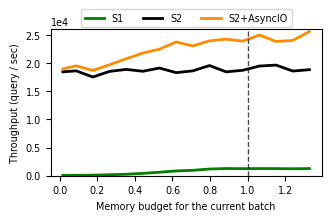

In [12]:
# compute tput query per sec
num_query = 15000
max_mem = 113

tput_query = {}
for k, v in st_query.items():
    k = k / max_mem
    tput_query[k] = num_query / v

tput_index = {}
for k, v in st_index.items():
    k = k / max_mem
    tput_index[k] = num_query / v

tput_index_async = {}
for k, v in st_index_async.items():
    k = k / max_mem
    tput_index_async[k] = num_query / v

# plot tput
linewidth = 2
# plt.figure(figsize=(2.86, 2.3))
plt.figure(figsize=(3.5, 1.9))
plt.plot(list(tput_query.keys()), list(tput_query.values()), label="S1", color='green', linewidth=linewidth, linestyle='-')
plt.plot(list(tput_index.keys()), list(tput_index.values()), label="S2", color='black', linewidth=linewidth)
plt.plot(list(tput_index_async.keys()), list(tput_index_async.values()), label="S2+AsyncIO", color='darkorange', linewidth=linewidth)

# vertical line
plt.axvline(x=1, color='black', linestyle='--', alpha=0.7, linewidth=linewidth-1)

# 1 row, 3 columns legend
# plt.legend(loc='upper center', bbox_to_anchor=(0.54, 1.17), ncol=3)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.17), ncol=3)
plt.xlabel("Memory budget for the current batch")
plt.ylabel("Throughput (query / sec)")

# make y-axis use scientific notation
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ylim(0, 26000)

# plt.tight_layout()
# plt.savefig("tmp/tput_memV2.pdf")
plt.savefig("plots/tput_mem.pdf", bbox_inches="tight")
plt.show()

In [14]:
def precent_faster(a, b):
    # a is the baseline
    return (b - a) / a

def times_faster(a, b):
    # a is the baseline
    return b / a

In [15]:
# list(tput_query.values())
# list(tput_index.values())
# list(tput_index_async.values())

# compute precent max decrease between tput_query and tput_index_async
max_decreases = []
for a, b in zip(list(tput_query.values()), list(tput_index_async.values())):
    p = precent_faster(a, b)
    max_decreases.append(p)

print("avg decrease: ", np.mean(max_decreases))

max_decreases = []
for a, b in zip(list(tput_index.values()), list(tput_index_async.values())):
    p = precent_faster(a, b)
    max_decreases.append(p)

print("avg decrease: ", np.mean(max_decreases))

avg decrease:  73.64563688431807
avg decrease:  0.1971118277390192


In [16]:
# query diversity

# st_query_diversity = {
#     0.0: 9.43839952,
#     0.1: 10.93816875,
#     0.2: 10.70763876,
#     0.3: 11.00994852,
#     0.4: 12.05738855,
#     0.5: 11.16794533,
#     0.6: 11.23277323,
#     0.7: 13.44501039,
#     0.8: 11.27035343,
#     0.9: 11.34796564,
#     1.0: 11.30618735
# }
# st_index_diversity = {
#     0.0: 1.14276421,
#     0.1: 1.95855080,
#     0.2: 1.83449230,
#     0.3: 1.89141592,
#     0.4: 1.88526955,
#     0.5: 1.89281210,
#     0.6: 1.88903056,
#     0.7: 1.90273121,
#     0.8: 1.96149863,
#     0.9: 1.92830793,
#     1.0: 1.94605508
# }
# st_index_async_diversity = {
#     0.0: 0.78801695,
#     0.1: 1.55864374,
#     0.2: 1.40223565,
#     0.3: 1.39977139,
#     0.4: 1.40591503,
#     0.5: 1.38263734,
#     0.6: 1.41171381,
#     0.7: 1.45423789,
#     0.8: 1.47577877,
#     0.9: 1.46389665,
#     1.0: 1.49676419
# }

num_query = 10000
st_index_async_diversity =  {
  0.0: 0.45217028,
  0.002: 0.74394389,
  0.004: 1.07313673,
  0.006: 1.14235309,
  0.008: 1.16521932,
  0.01: 1.41975398,
  0.05: 2.06885823,
  # 0.1: 2.0455493
}
st_index_diversity = {
  0.0: 0.58636054,
  0.002: 0.91676583,
  0.004: 1.22866432,
  0.006: 1.43039795,
  0.008: 1.54039739,
  0.01: 1.66379801,
  0.05: 2.11181633,
  # 0.1: 2.10928185
}
st_query_diversity = {
  0.0: 8.230743,
  0.002: 9.00914463,
  0.004: 9.83213899,
  0.006: 9.8606782,
  0.008: 10.14792845,
  0.01: 11.27789476,
  0.05: 12.15238989,
  # 0.1: 12.48343554
}

# convert to query per sec
tput_query_diversity = {}
for k, v in st_query_diversity.items():
    tput_query_diversity[float(str(k)[:5])] = num_query / v

tput_index_diversity = {}
for k, v in st_index_diversity.items():
    tput_index_diversity[float(str(k)[:5])] = num_query / v

tput_index_async_diversity = {}
for k, v in st_index_async_diversity.items():
    tput_index_async_diversity[float(str(k)[:5])] = num_query / v
  
tput_index_async_diversity

{0.0: 22115.562305421754,
 0.002: 13441.873956381307,
 0.004: 9318.477059302591,
 0.006: 8753.860857504224,
 0.008: 8582.075346982747,
 0.01: 7043.4738277683855,
 0.05: 4833.583981247473}

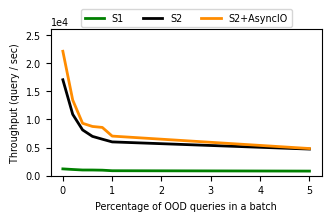

In [17]:
linewidth = 2 

# plot
# plt.figure(figsize=(4, 1.9))
plt.figure(figsize=(3.5, 1.9))
plt.plot(np.array(list(tput_query_diversity.keys()))*100, list(tput_query_diversity.values()), label="S1", color='green', linewidth=linewidth, linestyle='-')
plt.plot(np.array(list(tput_index_diversity.keys()))*100, list(tput_index_diversity.values()), label="S2", color='black', linewidth=linewidth)
plt.plot(np.array(list(tput_index_async_diversity.keys()))*100, list(tput_index_async_diversity.values()), label="S2+AsyncIO", color='darkorange', linewidth=linewidth)

# set xticks
# plt.xticks(np.arange(0, 0.051, 0.001))
# plt.xlim([0., 2])

# 1 row, 3 columns legend
# plt.legend(loc='upper center', bbox_to_anchor=(0.54, 1.17), ncol=3)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.17), ncol=3)
plt.xlabel("Percentage of OOD queries in a batch")
plt.ylabel("Throughput (query / sec)")

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ylim(0, 26000)

# plt.tight_layout()
plt.savefig("plots/tput_diversity.pdf", bbox_inches="tight")
plt.show()

In [18]:
# np.arange(0, 0.05, 0.001)

# compute precent max decrease between tput_query and tput_index_async
max_decreases = []
for a, b in zip(list(tput_query_diversity.values()), list(tput_index_async_diversity.values())):
    p = precent_faster(a, b)
    max_decreases.append(p)

print("avg decrease: ", np.mean(max_decreases))

max_decreases = []
for a, b in zip(list(tput_index_diversity.values()), list(tput_index_async_diversity.values())):
    p = precent_faster(a, b)
    max_decreases.append(p)

print("avg decrease: ", np.mean(max_decreases))

avg decrease:  9.090461471536457
avg decrease:  0.20582706403256368


In [19]:
max_decreases

[0.29676930558107456,
 0.23230507343772927,
 0.14492802795036183,
 0.25215046251592826,
 0.3219806465275568,
 0.17189177381281237,
 0.020764158402482698]

In [20]:
# compute percentage tput change compared to previous

def random_floats(size, low=0, high=1, seed=None):
    # if seed is not None: np.random.seed(seed)
    return [np.random.uniform(low, high) for _ in range(size)]

random_floats(1, -1., 1)[0]

-0.6967883374121273

In [21]:
from pprint import pprint

st = {"idx1": [1,2,3,4,5], 
     "idx2": [1,2,3,4], 
     "idx3": [1,2,3],
     "idx4": [1,2],
     "idx5": [1]}

pprint(st)
print()

dram_idx_dict = {"idx5": "idx3obj",
     "idx3": "idx3obj"}


dram_idxs = []
for k, v in dram_idx_dict.items():
    if k in st:
        dram_idxs.append((k,st[k]))
        del st[k]

# sort by length, small batch first, so can finish faster and leave more space for loading
dram_idxs = sorted(dram_idxs, key=lambda x: len(x[1]), reverse=False)
print(dram_idxs)

dram_idxs.extend(list(st.items()))
dram_idxs = dict(dram_idxs)
print()
print(dram_idxs)

for k, v in dram_idxs.items():
    print(k, v)

{'idx1': [1, 2, 3, 4, 5],
 'idx2': [1, 2, 3, 4],
 'idx3': [1, 2, 3],
 'idx4': [1, 2],
 'idx5': [1]}

[('idx5', [1]), ('idx3', [1, 2, 3])]

{'idx5': [1], 'idx3': [1, 2, 3], 'idx1': [1, 2, 3, 4, 5], 'idx2': [1, 2, 3, 4], 'idx4': [1, 2]}
idx5 [1]
idx3 [1, 2, 3]
idx1 [1, 2, 3, 4, 5]
idx2 [1, 2, 3, 4]
idx4 [1, 2]


In [22]:
mrs = [0., 0., 0., 0., 0., 0.001, 0.001, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.05, 0.1, 0.3, 0.5, 1.0]

# randomly pick 100 numbers from mrs
mrs = np.random.choice(mrs, 100)

for m in mrs:
    print(m, end=" ")

0.0 0.001 0.001 0.008 0.3 0.0 0.5 0.1 1.0 0.001 0.0 0.002 0.003 0.006 1.0 0.05 0.008 0.05 1.0 1.0 0.0 1.0 0.001 0.003 0.005 0.0 0.001 0.1 0.009 0.004 0.0 0.003 0.3 1.0 0.001 0.1 0.5 0.3 0.05 0.0 0.003 0.0 0.01 0.3 0.0 0.0 0.008 0.004 0.009 0.0 0.05 0.006 0.05 0.002 0.0 0.5 0.001 0.0 0.005 0.3 0.5 1.0 0.0 0.009 1.0 0.009 0.001 0.5 0.1 0.009 0.3 0.01 0.001 0.005 0.0 0.5 0.002 0.007 0.3 0.005 0.0 0.0 0.0 0.004 0.0 0.0 0.0 0.002 0.002 0.1 0.5 0.002 0.006 0.004 0.0 0.004 0.5 0.3 0.0 0.0 

In [23]:
num_vectors = 5
num_dimensions = 10

means = np.random.uniform(-1, 1, num_dimensions)
std_devs = np.random.uniform(0.1, 0.5, num_dimensions)

random_vectors = np.random.normal(loc=means, scale=std_devs, size=(num_vectors, num_dimensions))
random_vectors

array([[ 0.60235322, -0.70205287, -0.48632218, -0.53687197, -1.05623486,
         0.34751997, -0.85590456, -0.26123182,  0.41929236,  0.90219588],
       [ 0.83782663, -0.89311461, -0.33605799, -0.37842487, -0.11336681,
        -0.24578843, -0.96530683, -0.73067618,  1.16530123,  0.59602633],
       [ 0.85047836, -1.03008369, -0.49408334, -0.71551829, -1.24231949,
        -0.3060087 , -0.71606706,  0.34817097,  0.2065103 ,  1.08408215],
       [-0.37765259, -0.54159761, -0.39463581, -0.49756249, -0.70006999,
        -0.50167173, -0.52894279, -0.70032288,  0.80474432,  1.11634077],
       [ 0.88047903, -0.73395724, -0.4248955 , -0.53369049, -0.84522144,
        -0.92717591, -0.64479274,  0.40710179,  0.4947262 ,  1.18714592]])

# Serving Tputs

In [24]:
# read file line by line
lru_times = []
lru_tputs = []
lru_avg_tputs = []

fpth = "../logs/lru_tput.tmp"
with open(fpth, 'r') as f:
    for line in f:
        # print(line[:-1])
        t = float(line.split(" ")[1])
        tput = float(line.split(" ")[4])
        avg_tput = float(line.split(" ")[7])
        lru_times.append(t)
        lru_tputs.append(tput)
        lru_avg_tputs.append(avg_tput)

In [25]:
# read file line by line
lfu_times = []
lfu_tputs = []
lfu_avg_tputs = []

fpth = "../logs/lfu_tput.tmp"
with open(fpth, 'r') as f:
    for line in f:
        t = float(line.split(" ")[1])
        tput = float(line.split(" ")[4])
        avg_tput = float(line.split(" ")[7])
        lfu_times.append(t)
        lfu_tputs.append(tput)
        lfu_avg_tputs.append(avg_tput)

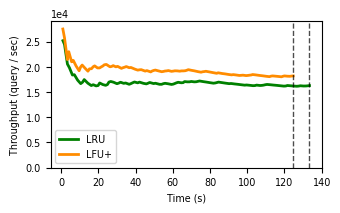

In [26]:
# plot
# plt.figure(figsize=(4, 1.9))
plt.figure(figsize=(3.5, 1.9))
# plt.plot(lru_times, lru_tputs, label="Tput", color='green', linewidth=1, linestyle='-')
plt.plot(lru_times, lru_avg_tputs, label="LRU", color='green', linewidth=2, linestyle='-')

# plt.plot(lfu_times, lfu_tputs, label="Tput", color='darkorange', linewidth=1, linestyle='-')
plt.plot(lfu_times, lfu_avg_tputs, label="LFU+", color='darkorange', linewidth=2)

# add vertical lines
plt.axvline(x=lru_times[-1], color='black', linestyle='--', alpha=0.7, linewidth=1)
plt.axvline(x=lfu_times[-1], color='black', linestyle='--', alpha=0.7, linewidth=1)


plt.ylim(0, 29000)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.legend(loc='lower left')
plt.xlabel("Time (s)")
plt.ylabel("Throughput (query / sec)")
# plt.tight_layout()
# plt.savefig("tmp/lru_lfu_tput.pdf")
plt.savefig("plots/lru_lfu_tput.pdf", bbox_inches="tight")
plt.show()

In [37]:
max_decreases = []
for a, b in zip(lru_avg_tputs, lfu_avg_tputs):
    p = precent_faster(a, b)
    max_decreases.append(p)

print("avg decrease: ", np.mean(max_decreases))

avg decrease:  0.14512973834858775
